# Resolution Refinement for Enlarged Scale Images Using GANs

In [3]:
#starting to build GANs network
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
images=np.load('data.npy')
resized8=np.load('array8.npy')
%matplotlib inline

In [4]:
print("Training set size:\t",len(images))

Training set size:	 50000


In [5]:
images=images[:200]
resized8=resized8[:200]
print(len(images))

200


In [6]:
import tensorflow.contrib.layers as lays
def generator(input,reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        net = lays.conv2d_transpose(input,16, [5, 5], stride=2, padding='SAME')
        net = lays.conv2d_transpose(net,32, [5, 5], stride=2, padding='SAME')
        net = lays.conv2d_transpose(net, 3, [5, 5], stride=1, padding='SAME', activation_fn=tf.nn.tanh)
        return net

In [7]:
def discriminator(input,reuse=True):
    with tf.variable_scope('dis',reuse=reuse):
        net = lays.conv2d(input, 32, [5, 5], stride=2, padding='SAME',activation_fn=tf.nn.relu) #16 x16 x 32
        net = lays.conv2d(net, 16, [5, 5], stride=2, padding='SAME',activation_fn=tf.nn.relu) # 8 x 8 x 16
        net = lays.conv2d(net, 8, [5, 5], stride=4, padding='SAME',activation_fn=tf.nn.relu) #--> 2 x 2 x 8
        dim = int(np.prod(net.get_shape()[1:]))
        fc1 = tf.reshape(net, shape=[-1, dim], name='fc1')
        w2 = tf.get_variable('w2', shape=[fc1.shape[-1], 1], dtype=tf.float32,initializer=tf.truncated_normal_initializer(stddev=0.02))
        b2 = tf.get_variable('b2', shape=[1], dtype=tf.float32,initializer=tf.constant_initializer(0.0))
        logits = tf.add(tf.matmul(fc1, w2), b2, name='logits')
        Dis_out = tf.nn.sigmoid(logits)
        return logits

In [8]:
tf.reset_default_graph()
real_images=tf.placeholder(tf.float32, (None,32, 32, 3))
inputs_= tf.placeholder(tf.float32, (None,8, 8, 3))
G=generator(inputs_)
D_real=discriminator(real_images,reuse=None)
D_fake=discriminator(G,reuse=True)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:

def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))
D_real_loss=loss_func(D_real,tf.ones_like(D_real)) #Smoothing for generalization
D_fake_loss=loss_func(D_fake,tf.zeros_like(D_fake))
D_loss=D_real_loss#+D_fake_loss
G_loss=loss_func(D_fake,tf.ones_like(D_fake))
#D_loss=tf.reduce_mean(D_fake)-tf.reduce_mean(D_real)
#G_loss=-tf.reduce_mean(D_fake)
S_loss = tf.reduce_mean((G-real_images)**2)


In [10]:
'''
D_loss =-tf.reduce_mean(tf.log(D_real) + tf.log(1- D_fake))
G_loss =-tf.reduce_mean(tf.log(D_fake))
S_loss = tf.reduce_mean((G-real_images)**2)
'''

'\nD_loss =-tf.reduce_mean(tf.log(D_real) + tf.log(1- D_fake))\nG_loss =-tf.reduce_mean(tf.log(D_fake))\nS_loss = tf.reduce_mean((G-real_images)**2)\n'

==>>*Due to PC restriction for Training large number of the data,and it takes many times for training, here I run the training iteration only for 200 sample images, and 100 epochs*

In [11]:
lr=0.0002 #0.0002
gama=0.2
#Do this when multiple networks interact with each other
tvars=tf.trainable_variables()  #returns all variables created(the two variable scopes) and makes trainable true
d_vars=[var for var in tvars if 'dis' in var.name]
g_vars=[var for var in tvars if 'gen' in var.name]
GENLOSS=(1-gama)*G_loss+gama*S_loss# reducing sloss 0.2,0.1,...more close to gans
D_trainer=tf.train.AdamOptimizer(lr).minimize(D_loss,var_list=d_vars)
G_trainer=tf.train.AdamOptimizer(lr).minimize(GENLOSS,var_list=g_vars) #0.001*g_loss+d_loss
#G_trainer=tf.train.AdamOptimizer(lr).minimize((0.001*G_loss+D_loss),var_list=g_vars)
batch_size=20
epochs=100
h=len(images)
init=tf.global_variables_initializer()

In [12]:
samples=[] #generator examples
ADVloss=[]
MSEloss=[]
Daverageloss=[]
Gaverageloss=[]
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
        num_batches=h//batch_size
        print('epoch ',epoch)
        DLOSS=[]
        GLOSS=[]
        G_LOSS=[]
        S_LOSS=[]
        for i in range(num_batches):
            #m=i*batch_size
            batch_images=images[i*batch_size : (i+1)*batch_size].reshape(batch_size,32,32,3)
            batch_z=resized8[i*batch_size : (i+1)*batch_size].reshape(batch_size,8,8,3)
            Go=sess.run(generator(inputs_,reuse=True),feed_dict={inputs_:batch_z})
           # _=sess.run(D_trainer,feed_dict={real_images:batch_images,inputs_:batch_z})
           # _=sess.run(G_trainer,feed_dict={inputs_:batch_z})
            Dloss, _ = sess.run([D_loss, D_trainer], feed_dict={real_images:batch_images,G:Go})
            for dd in range(5): 
                Genloss,ADV,MSE, _ = sess.run([GENLOSS,G_loss,S_loss,G_trainer], feed_dict={inputs_:batch_z,real_images:batch_images})
            #Genloss, _ = sess.run([G_loss, G_trainer], feed_dict={inputs_:batch_z,real_images:batch_images})
            G_LOSS.append(ADV)
            S_LOSS.append(MSE)
            DLOSS.append(Dloss)
            GLOSS.append(Genloss)
            if epoch==epochs-1:
                samples.append(Go)
            #Genloss, _ = sess.run([g_loss, train_Gen], feed_dict={Sr:G,Hr:batch_images})
            print('epoch {} batch number {}   discrim batch loss: {} Gen batch loss: {}'.format(epoch,i,Dloss,Genloss))
        MeanDloss=np.mean(DLOSS)
        MeanGlos=np.mean(GLOSS)
        meanADVloss=np.mean(G_LOSS)
        meanMSEloss=np.mean(S_LOSS)
        Daverageloss.append(np.mean(DLOSS))
        Gaverageloss.append(MeanGlos)
        ADVloss.append(meanADVloss)
        MSEloss.append(meanMSEloss)
        print(' Average discrim loss: {} Average Gen loss: {} Average MSE Loss: {}'.format(MeanDloss,MeanGlos,meanMSEloss))
       
     

epoch  0
epoch 0 batch number 0   discrim batch loss: 0.6920310854911804 Gen batch loss: 0.6031760573387146
epoch 0 batch number 1   discrim batch loss: 0.6914992332458496 Gen batch loss: 0.5990027189254761
epoch 0 batch number 2   discrim batch loss: 0.6904195547103882 Gen batch loss: 0.5981895923614502
epoch 0 batch number 3   discrim batch loss: 0.6890206336975098 Gen batch loss: 0.5875774025917053
epoch 0 batch number 4   discrim batch loss: 0.6882578730583191 Gen batch loss: 0.5761016607284546
epoch 0 batch number 5   discrim batch loss: 0.6857084035873413 Gen batch loss: 0.575605571269989
epoch 0 batch number 6   discrim batch loss: 0.6850918531417847 Gen batch loss: 0.5641913414001465
epoch 0 batch number 7   discrim batch loss: 0.6832000017166138 Gen batch loss: 0.5548108816146851
epoch 0 batch number 8   discrim batch loss: 0.6823347806930542 Gen batch loss: 0.553061842918396
epoch 0 batch number 9   discrim batch loss: 0.6793721318244934 Gen batch loss: 0.5482549667358398
 Av

epoch 7 batch number 3   discrim batch loss: 0.002080702455714345 Gen batch loss: 0.006968791130930185
epoch 7 batch number 4   discrim batch loss: 0.0027668694965541363 Gen batch loss: 0.00640543457120657
epoch 7 batch number 5   discrim batch loss: 0.0008544187294319272 Gen batch loss: 0.007295326329767704
epoch 7 batch number 6   discrim batch loss: 0.003381207585334778 Gen batch loss: 0.006451231427490711
epoch 7 batch number 7   discrim batch loss: 0.0009029866196215153 Gen batch loss: 0.005330767948180437
epoch 7 batch number 8   discrim batch loss: 0.0037218467332422733 Gen batch loss: 0.00650204299017787
epoch 7 batch number 9   discrim batch loss: 0.0015966646606102586 Gen batch loss: 0.0052580093033611774
 Average discrim loss: 0.0027027868200093508 Average Gen loss: 0.006746137049049139 Average MSE Loss: 0.030671829357743263
epoch  8
epoch 8 batch number 0   discrim batch loss: 0.0019728930201381445 Gen batch loss: 0.006548150908201933
epoch 8 batch number 1   discrim batch 

epoch 14 batch number 3   discrim batch loss: 6.906946509843692e-05 Gen batch loss: 0.0036622737534344196
epoch 14 batch number 4   discrim batch loss: 0.00014954533253330737 Gen batch loss: 0.0033817579969763756
epoch 14 batch number 5   discrim batch loss: 2.296880484209396e-05 Gen batch loss: 0.003577010938897729
epoch 14 batch number 6   discrim batch loss: 0.000523189315572381 Gen batch loss: 0.003240870079025626
epoch 14 batch number 7   discrim batch loss: 3.489248047117144e-05 Gen batch loss: 0.002647797344252467
epoch 14 batch number 8   discrim batch loss: 0.0004423291829880327 Gen batch loss: 0.0034650007728487253
epoch 14 batch number 9   discrim batch loss: 0.00013783486792817712 Gen batch loss: 0.0027388434391468763
 Average discrim loss: 0.000183083611773327 Average Gen loss: 0.0033486727625131607 Average MSE Loss: 0.01612517610192299
epoch  15
epoch 15 batch number 0   discrim batch loss: 0.00018099740555044264 Gen batch loss: 0.0036097343545407057
epoch 15 batch number

epoch 21 batch number 2   discrim batch loss: 8.270323633041698e-06 Gen batch loss: 0.002805328695103526
epoch 21 batch number 3   discrim batch loss: 6.443980055337306e-06 Gen batch loss: 0.003110503079369664
epoch 21 batch number 4   discrim batch loss: 2.1884217858314514e-05 Gen batch loss: 0.0027285567484796047
epoch 21 batch number 5   discrim batch loss: 1.6732313952161348e-06 Gen batch loss: 0.0029684093315154314
epoch 21 batch number 6   discrim batch loss: 0.00013202002446632832 Gen batch loss: 0.0026139658875763416
epoch 21 batch number 7   discrim batch loss: 3.2304560591001064e-06 Gen batch loss: 0.002217794768512249
epoch 21 batch number 8   discrim batch loss: 9.785544534679502e-05 Gen batch loss: 0.0028059973847121
epoch 21 batch number 9   discrim batch loss: 2.1712321540690027e-05 Gen batch loss: 0.002257392043247819
 Average discrim loss: 3.470011506578885e-05 Average Gen loss: 0.002724569058045745 Average MSE Loss: 0.013454580679535866
epoch  22
epoch 22 batch number

epoch 28 batch number 1   discrim batch loss: 3.1324477731686784e-06 Gen batch loss: 0.0024770228192210197
epoch 28 batch number 2   discrim batch loss: 1.9431772670941427e-06 Gen batch loss: 0.0026055946946144104
epoch 28 batch number 3   discrim batch loss: 1.4784700397285633e-06 Gen batch loss: 0.0029237563721835613
epoch 28 batch number 4   discrim batch loss: 6.682663752144435e-06 Gen batch loss: 0.0024729256983846426
epoch 28 batch number 5   discrim batch loss: 3.2173608133234666e-07 Gen batch loss: 0.0027460549026727676
epoch 28 batch number 6   discrim batch loss: 5.485540532390587e-05 Gen batch loss: 0.0023832726292312145
epoch 28 batch number 7   discrim batch loss: 7.544416007476684e-07 Gen batch loss: 0.0020673058461397886
epoch 28 batch number 8   discrim batch loss: 3.916840432793833e-05 Gen batch loss: 0.002572141122072935
epoch 28 batch number 9   discrim batch loss: 6.868200671306113e-06 Gen batch loss: 0.0020574233494699
 Average discrim loss: 1.2946041351824533e-05 

epoch 35 batch number 0   discrim batch loss: 6.872440280858427e-06 Gen batch loss: 0.00252629560418427
epoch 35 batch number 1   discrim batch loss: 1.1625270417425781e-06 Gen batch loss: 0.002238364890217781
epoch 35 batch number 2   discrim batch loss: 7.009963951531972e-07 Gen batch loss: 0.0024344853591173887
epoch 35 batch number 3   discrim batch loss: 5.245523198027513e-07 Gen batch loss: 0.00277048721909523
epoch 35 batch number 4   discrim batch loss: 2.9330853976716753e-06 Gen batch loss: 0.0022443837951868773
epoch 35 batch number 5   discrim batch loss: 9.970208481036025e-08 Gen batch loss: 0.002564904745668173
epoch 35 batch number 6   discrim batch loss: 2.9289129088283516e-05 Gen batch loss: 0.0022175072226673365
epoch 35 batch number 7   discrim batch loss: 2.6955208909384964e-07 Gen batch loss: 0.001923760399222374
epoch 35 batch number 8   discrim batch loss: 2.0516807126114145e-05 Gen batch loss: 0.002404568949714303
epoch 35 batch number 9   discrim batch loss: 3.0

epoch 42 batch number 0   discrim batch loss: 3.676320147860679e-06 Gen batch loss: 0.002369557274505496
epoch 42 batch number 1   discrim batch loss: 4.956207817485847e-07 Gen batch loss: 0.0020946061704307795
epoch 42 batch number 2   discrim batch loss: 2.9111367894074647e-07 Gen batch loss: 0.0023097333032637835
epoch 42 batch number 3   discrim batch loss: 2.1309111275513715e-07 Gen batch loss: 0.0026623967569321394
epoch 42 batch number 4   discrim batch loss: 1.4358244015966193e-06 Gen batch loss: 0.0020928189624100924
epoch 42 batch number 5   discrim batch loss: 3.5923502395007745e-08 Gen batch loss: 0.0024225672241300344
epoch 42 batch number 6   discrim batch loss: 1.7009590010275133e-05 Gen batch loss: 0.0020883833058178425
epoch 42 batch number 7   discrim batch loss: 1.1006561351223354e-07 Gen batch loss: 0.001827838597819209
epoch 42 batch number 8   discrim batch loss: 1.1671142601699103e-05 Gen batch loss: 0.002276194980368018
epoch 42 batch number 9   discrim batch lo

epoch 49 batch number 0   discrim batch loss: 2.121550778610981e-06 Gen batch loss: 0.0022621063981205225
epoch 49 batch number 1   discrim batch loss: 2.3446088448508817e-07 Gen batch loss: 0.0019942857325077057
epoch 49 batch number 2   discrim batch loss: 1.3455891689773125e-07 Gen batch loss: 0.0022034260910004377
epoch 49 batch number 3   discrim batch loss: 9.646250731520922e-08 Gen batch loss: 0.002581576583907008
epoch 49 batch number 4   discrim batch loss: 7.682087925786618e-07 Gen batch loss: 0.0019972813315689564
epoch 49 batch number 5   discrim batch loss: 1.4673458004210715e-08 Gen batch loss: 0.0023127838503569365
epoch 49 batch number 6   discrim batch loss: 1.0546198609517887e-05 Gen batch loss: 0.001985260983929038
epoch 49 batch number 7   discrim batch loss: 5.012492465539253e-08 Gen batch loss: 0.0017521196277812123
epoch 49 batch number 8   discrim batch loss: 7.121295311662834e-06 Gen batch loss: 0.0021835151128470898
epoch 49 batch number 9   discrim batch loss

epoch 56 batch number 0   discrim batch loss: 1.3053610246060998e-06 Gen batch loss: 0.002174747409299016
epoch 56 batch number 1   discrim batch loss: 1.211546702961641e-07 Gen batch loss: 0.0019071410642936826
epoch 56 batch number 2   discrim batch loss: 6.804722829656384e-08 Gen batch loss: 0.0021120370365679264
epoch 56 batch number 3   discrim batch loss: 4.785469442936119e-08 Gen batch loss: 0.0025040300097316504
epoch 56 batch number 4   discrim batch loss: 4.427010935614817e-07 Gen batch loss: 0.001918441615998745
epoch 56 batch number 5   discrim batch loss: 6.6556475886159205e-09 Gen batch loss: 0.0022294551599770784
epoch 56 batch number 6   discrim batch loss: 6.919331553945085e-06 Gen batch loss: 0.0019039320759475231
epoch 56 batch number 7   discrim batch loss: 2.501156792789061e-08 Gen batch loss: 0.0016920404741540551
epoch 56 batch number 8   discrim batch loss: 4.605738013196969e-06 Gen batch loss: 0.0021097783464938402
epoch 56 batch number 9   discrim batch loss: 

epoch 63 batch number 0   discrim batch loss: 8.506189033141709e-07 Gen batch loss: 0.0021033622324466705
epoch 63 batch number 1   discrim batch loss: 6.7735058451035e-08 Gen batch loss: 0.0018341703107580543
epoch 63 batch number 2   discrim batch loss: 3.7309813905039846e-08 Gen batch loss: 0.002036849269643426
epoch 63 batch number 3   discrim batch loss: 2.577619717669677e-08 Gen batch loss: 0.0024446132592856884
epoch 63 batch number 4   discrim batch loss: 2.725660408486874e-07 Gen batch loss: 0.0018537341384217143
epoch 63 batch number 5   discrim batch loss: 3.3167490975927194e-09 Gen batch loss: 0.0021513088140636683
epoch 63 batch number 6   discrim batch loss: 4.773794444190571e-06 Gen batch loss: 0.0018327139550819993
epoch 63 batch number 7   discrim batch loss: 1.354557888078034e-08 Gen batch loss: 0.0016406640643253922
epoch 63 batch number 8   discrim batch loss: 3.1378926905745175e-06 Gen batch loss: 0.0020448823925107718
epoch 63 batch number 9   discrim batch loss: 

epoch 70 batch number 0   discrim batch loss: 5.829189149153535e-07 Gen batch loss: 0.002044553868472576
epoch 70 batch number 1   discrim batch loss: 4.0567506687239074e-08 Gen batch loss: 0.0017767781391739845
epoch 70 batch number 2   discrim batch loss: 2.195721116038385e-08 Gen batch loss: 0.0019751358777284622
epoch 70 batch number 3   discrim batch loss: 1.4922575175546626e-08 Gen batch loss: 0.0023979200050234795
epoch 70 batch number 4   discrim batch loss: 1.7776088157006598e-07 Gen batch loss: 0.001803562161512673
epoch 70 batch number 5   discrim batch loss: 1.7943901919892369e-09 Gen batch loss: 0.002084434265270829
epoch 70 batch number 6   discrim batch loss: 3.4404813504806953e-06 Gen batch loss: 0.0017761089839041233
epoch 70 batch number 7   discrim batch loss: 7.880191610354359e-09 Gen batch loss: 0.001595385605469346
epoch 70 batch number 8   discrim batch loss: 2.2367835299519356e-06 Gen batch loss: 0.0019978529307991266
epoch 70 batch number 9   discrim batch loss

epoch 77 batch number 0   discrim batch loss: 4.168818179550726e-07 Gen batch loss: 0.0019958550110459328
epoch 77 batch number 1   discrim batch loss: 2.5752129317879735e-08 Gen batch loss: 0.0017272490076720715
epoch 77 batch number 2   discrim batch loss: 1.3719761327024571e-08 Gen batch loss: 0.0019271861528977752
epoch 77 batch number 3   discrim batch loss: 9.18384035486497e-09 Gen batch loss: 0.0023592079523950815
epoch 77 batch number 4   discrim batch loss: 1.2169529384209454e-07 Gen batch loss: 0.0017653346294537187
epoch 77 batch number 5   discrim batch loss: 1.0405283301651025e-09 Gen batch loss: 0.0020310403779149055
epoch 77 batch number 6   discrim batch loss: 2.5724330043885857e-06 Gen batch loss: 0.0017259020823985338
epoch 77 batch number 7   discrim batch loss: 4.870380987398448e-09 Gen batch loss: 0.0015644555678591132
epoch 77 batch number 8   discrim batch loss: 1.6563768667765544e-06 Gen batch loss: 0.001957946689799428
epoch 77 batch number 9   discrim batch lo

epoch 84 batch number 0   discrim batch loss: 3.089323570293345e-07 Gen batch loss: 0.0019580197986215353
epoch 84 batch number 1   discrim batch loss: 1.7158516385507028e-08 Gen batch loss: 0.001687119947746396
epoch 84 batch number 2   discrim batch loss: 9.01110563944485e-09 Gen batch loss: 0.001890453975647688
epoch 84 batch number 3   discrim batch loss: 5.9477729408285995e-09 Gen batch loss: 0.0023289730306714773
epoch 84 batch number 4   discrim batch loss: 8.673977447415382e-08 Gen batch loss: 0.0017338099423795938
epoch 84 batch number 5   discrim batch loss: 6.392300577751087e-10 Gen batch loss: 0.0019887550733983517
epoch 84 batch number 6   discrim batch loss: 1.9831002191494917e-06 Gen batch loss: 0.0016873037675395608
epoch 84 batch number 7   discrim batch loss: 3.16588644189153e-09 Gen batch loss: 0.0015392828499898314
epoch 84 batch number 8   discrim batch loss: 1.2660437960221316e-06 Gen batch loss: 0.0019233457278460264
epoch 84 batch number 9   discrim batch loss: 

epoch 91 batch number 0   discrim batch loss: 2.3580298602610128e-07 Gen batch loss: 0.0019288868643343449
epoch 91 batch number 1   discrim batch loss: 1.1901745367026706e-08 Gen batch loss: 0.0016536785988137126
epoch 91 batch number 2   discrim batch loss: 6.168889399305044e-09 Gen batch loss: 0.0018610164988785982
epoch 91 batch number 3   discrim batch loss: 4.018947397099737e-09 Gen batch loss: 0.0023057388607412577
epoch 91 batch number 4   discrim batch loss: 6.392716045411362e-08 Gen batch loss: 0.0017089818138629198
epoch 91 batch number 5   discrim batch loss: 4.11981421200025e-10 Gen batch loss: 0.001954433973878622
epoch 91 batch number 6   discrim batch loss: 1.5680876686019474e-06 Gen batch loss: 0.00165754824411124
epoch 91 batch number 7   discrim batch loss: 2.1461059596106224e-09 Gen batch loss: 0.0015195764135569334
epoch 91 batch number 8   discrim batch loss: 9.934765330399387e-07 Gen batch loss: 0.001894941320642829
epoch 91 batch number 9   discrim batch loss: 6

epoch 98 batch number 0   discrim batch loss: 1.844785657567627e-07 Gen batch loss: 0.0019033525604754686
epoch 98 batch number 1   discrim batch loss: 8.537028861610452e-09 Gen batch loss: 0.0016254152869805694
epoch 98 batch number 2   discrim batch loss: 4.371712769568603e-09 Gen batch loss: 0.0018374263308942318
epoch 98 batch number 3   discrim batch loss: 2.8136291074787323e-09 Gen batch loss: 0.0022869850508868694
epoch 98 batch number 4   discrim batch loss: 4.8446061384765926e-08 Gen batch loss: 0.0016872724518179893
epoch 98 batch number 5   discrim batch loss: 2.7635099764111715e-10 Gen batch loss: 0.0019265706650912762
epoch 98 batch number 6   discrim batch loss: 1.2664764881265e-06 Gen batch loss: 0.001634520711377263
epoch 98 batch number 7   discrim batch loss: 1.5067120884282303e-09 Gen batch loss: 0.0015050455695018172
epoch 98 batch number 8   discrim batch loss: 7.968803288349591e-07 Gen batch loss: 0.0018724285764619708
epoch 98 batch number 9   discrim batch loss:

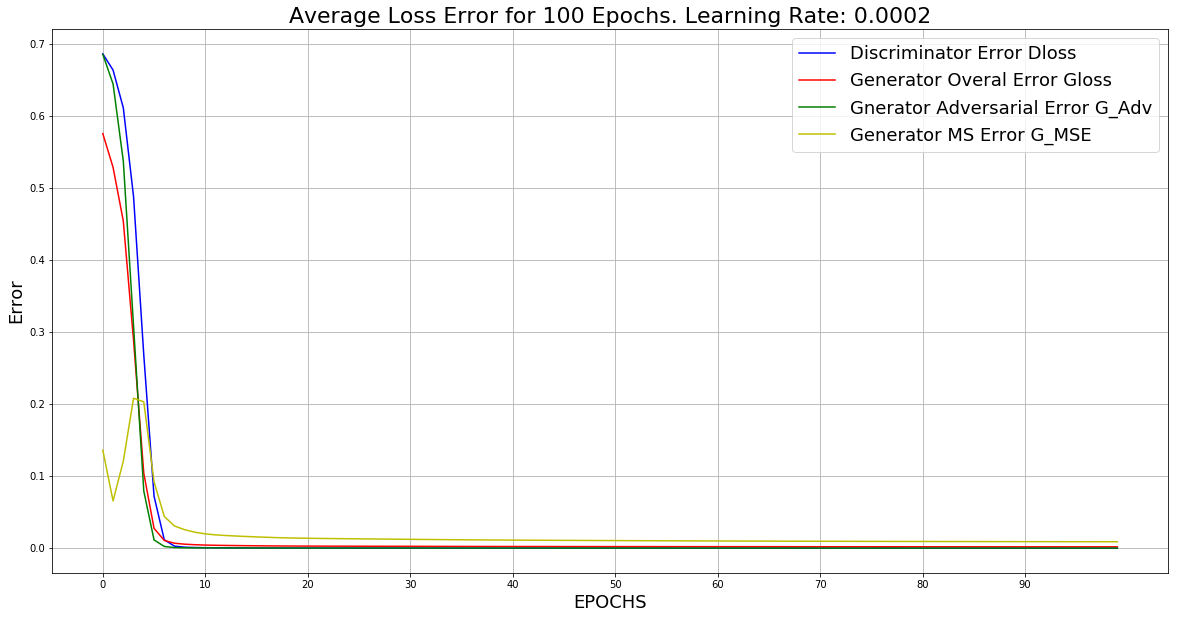

In [25]:
t=np.arange(epochs)
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.title('Average Loss Error for {} Epochs. Learning Rate: {}'.format(epochs,lr),fontsize=22)
plt.plot(t,Daverageloss,color='b',label='Discriminator Error Dloss')
plt.plot(t,Gaverageloss,color='r',label='Generator Overal Error Gloss')
plt.plot(t,ADVloss,color='g',label='Gnerator Adversarial Error G_Adv')
plt.plot(t,MSEloss,color='y',label='Generator MS Error G_MSE')
plt.xticks(np.arange(0,epochs,10))
#plt.yticks(np.arange(0,0.7,0.02))
plt.xlabel('EPOCHS',fontsize=18)
plt.ylabel('Error',fontsize=18)
plt.gca().legend(prop={'size': 18})
plt.grid(True)

## Predicted Images (32 x 32) From Low Scale Images(8 X 8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


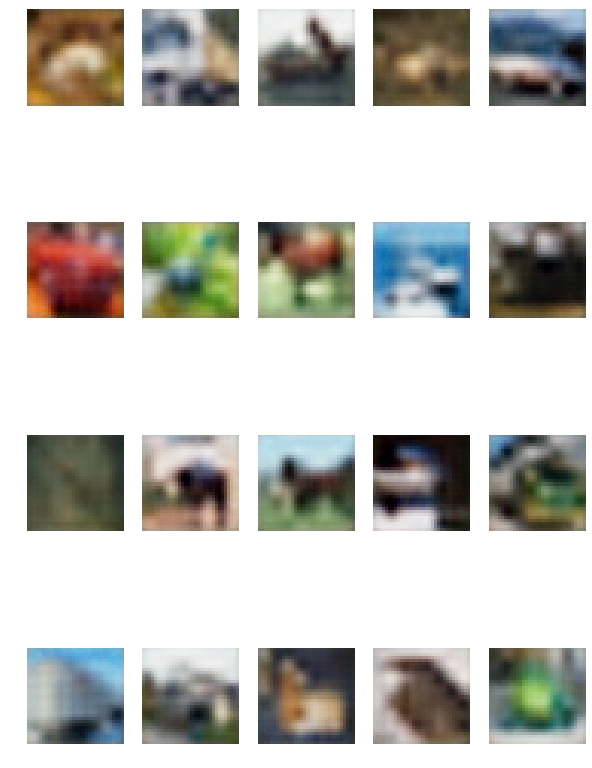

In [26]:
H=np.reshape(samples,(h,32,32,3))
fig=plt.figure(figsize=(10, 15))
columns = 5
rows = 4
for i in range(0, columns*rows ):
    #img = np.random.randint(10, size=(h,w))
    img=H[i]
    fig.add_subplot(rows, columns, (i+1))
    plt.axis('off')
    plt.imshow(img)
plt.show()

In [27]:
np.shape(samples)

(10, 20, 32, 32, 3)

## **Original Low Scale Images(8x8) From CIFAR10 dataset**

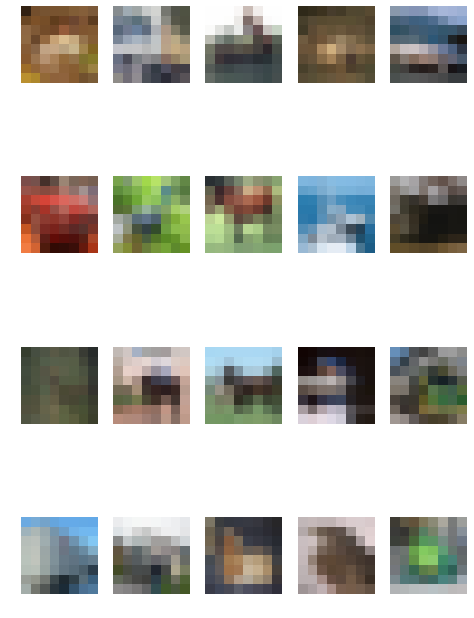

In [28]:
columns = 5
rows = 4
fig=plt.figure(figsize=(8,12))
for i in range(0, columns*rows ):
    #img = np.random.randint(10, size=(h,w))
    img=resized8[i]
    fig.add_subplot(rows, columns, (i+1))
    plt.axis('off')
    plt.imshow(img)
plt.show()

## **Original  Images( 32 x 32) From CIFAR10 dataset**

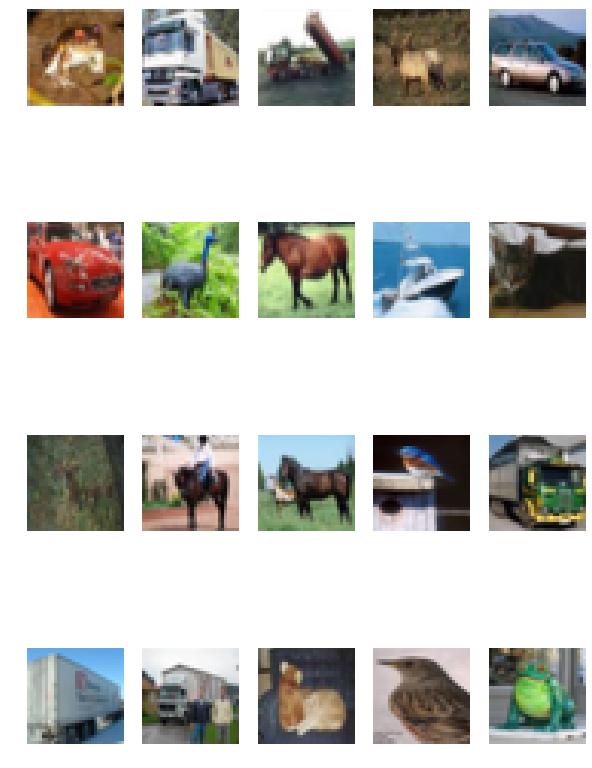

In [29]:
columns = 5
rows = 4
fig=plt.figure(figsize=(10,15))
for i in range(0, columns*rows ):
    #img = np.random.randint(10, size=(h,w))
    img=images[i]
    fig.add_subplot(rows, columns, (i+1))
    plt.axis('off')
    plt.imshow(img)
plt.show()

In [30]:
'''
H=np.reshape(samples,(batch_size*num_batches,32,32,3))     
y = images[:50]
y_ = H[:50]

con = tf.confusion_matrix(labels=y_, predictions=y )
sess = tf.Session()
with sess.as_default():
        print(sess.run(con))
'''

'\nH=np.reshape(samples,(batch_size*num_batches,32,32,3))     \ny = images[:50]\ny_ = H[:50]\n\ncon = tf.confusion_matrix(labels=y_, predictions=y )\nsess = tf.Session()\nwith sess.as_default():\n        print(sess.run(con))\n'

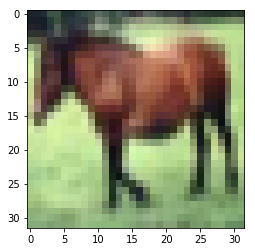

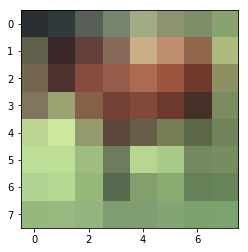

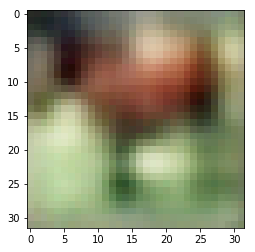

In [31]:
plt.figure(13)
plt.imshow(images[7], cmap='binary')
plt.figure(14)
plt.imshow(resized8[7], cmap='binary')
plt.figure(15)
plt.imshow(H[7], cmap='binary')